In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Embedding Feature Errors, Performance
In hierarchical encoding, more general NAICS categories are worse than specific.  For DGI clusters, it's the opposite.  Why? 

This notebook contains some examination of error rates for NAICS vs DGI encodings.  It also looks at the performance of encodings alone

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import importlib, os, pickle, re

In [3]:
import seaborn as sns

In [4]:
import sklearn as sk

In [5]:
from sba_gnn.sba_gnn import sg_plot 
sg_plot.plot_defaults()

In [6]:
import shap
import xgboost as xgb

In [7]:
import matplotlib.pyplot as plt

## Import Data

In [8]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [9]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

##### Hierarchical encodings only
Map the DGI based encoded feature into the loans

In [10]:
hier_df = pd.read_parquet(Path(setup.temp_path).joinpath('65_DATA_dgi_mhier.parquet'))

In [11]:
print(list(hier_df.columns))

['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'target', 'mhier_NAICS', 'menc_dgi', 'NAICS']


In [12]:
sba_loans = sba_loans.merge(hier_df[['LoanNr_ChkDgt','menc_dgi']],
                            on='LoanNr_ChkDgt')

In [13]:
sba_loans.shape

(688081, 59)

##### Get predictors

In [14]:
with open(Path(setup.temp_path).joinpath('10_DATA_features_predict.pkl'), 'rb') as fin:
    predictors_naics = pickle.load(fin)
print(predictors_naics)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'mhier_NAICS']


##### Predictions

In [15]:
pred_dgi = pd.read_parquet(Path(setup.temp_path).joinpath('65_DATA_combined_predictions.parquet'))
pred_naics = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_predictions.parquet'))

In [16]:
pred_dgi = pred_dgi.merge(sba_loans[['LoanNr_ChkDgt', 'NAICS', 'menc_dgi', 'menc_NAICS']],
                          on='LoanNr_ChkDgt')

In [17]:
pred_naics = pred_naics.drop(columns='NAICS', errors='ignore') \
    .merge(sba_loans[['LoanNr_ChkDgt', 'NAICS', 'mhier_NAICS', 'menc_NAICS']],
                          on='LoanNr_ChkDgt')

## Encoded Values - Metrics
Look at the performance of the encodings alone, separate from XGBoost or other models. What is the performance on train, test, holdout? 

In [18]:
# Do a simple threshold to get basic metrics; this is for comparison 
pred_naics['pred_bin_targ'] = np.where(pred_naics['menc_NAICS'] >= 0.2, 1, 0)

In [19]:
# How good is the standard target encoding as its own model?
metrics_mhier_targ_dset  = pred_naics.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.pred_bin_targ, x.pred_bin_targ)) \
    .reset_index()
metrics_mhier_targ_dset_test = pred_naics[pred_naics['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.pred_bin_targ, x.pred_bin_targ)) \
    .reset_index()
metrics_mhier_targ = pd.concat([metrics_mhier_targ_dset, metrics_mhier_targ_dset_test])
metrics_mhier_targ
metrics_mhier_targ.to_csv(Path(setup.temp_path).joinpath('81_REPORT_embedding_perf_menc_NAICS.csv'), index=False)

In [20]:
pred_naics['pred_bin_menc'] = np.where(pred_naics['mhier_NAICS'] >= 0.2, 1, 0)

In [21]:
# What about hiererchical encoding by NAICS?
metrics_mhier_naics_dset  = pred_naics.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.pred_bin_menc, x.mhier_NAICS)) \
    .reset_index()
metrics_mhier_naics_dset_test = pred_naics[pred_naics['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.pred_bin_menc, x.mhier_NAICS)) \
    .reset_index()
metrics_mhier_naics = pd.concat([metrics_mhier_naics_dset, metrics_mhier_naics_dset_test])
metrics_mhier_naics
metrics_mhier_naics.to_csv(Path(setup.temp_path).joinpath('81_REPORT_embedding_perf_mhier_NAICS.csv'), index=False)

In [22]:
pred_dgi['pred_bin_menc'] = np.where(pred_dgi['menc_dgi'] >= 0.2, 1, 0)

In [51]:
# What about DGI encoding
metrics_mhier_dgi_dset  = pred_dgi.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.pred_bin_menc, x.menc_dgi)) \
    .reset_index()
metrics_mhier_dgi_dset_test = pred_dgi[pred_dgi['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.pred_bin_menc, x.menc_dgi)) \
    .reset_index()
metrics_mhier_dgi = pd.concat([metrics_mhier_dgi_dset, metrics_mhier_dgi_dset_test])
metrics_mhier_dgi
metrics_mhier_dgi.to_csv(Path(setup.temp_path).joinpath('81_REPORT_embedding_perf_mehc_dgi.csv'), index=False)

## Histograms - Encoded Values

In [24]:
pred_dgi_ho = pred_dgi[pred_dgi['dset_naics_holdout'] ==1].copy()
pred_naics_ho = pred_naics[pred_naics['dset_naics_holdout'] ==1].copy()

In [25]:
pred_naics['mhier_NAICS'].describe()

count    688081.000000
mean          0.203906
std           0.095690
min           0.012987
25%           0.126003
50%           0.205592
75%           0.264286
max           0.572148
Name: mhier_NAICS, dtype: float64

In [26]:
pred_naics_ho['mhier_NAICS'].describe()

count    65052.000000
mean         0.196476
std          0.082249
min          0.036665
25%          0.110215
50%          0.226657
75%          0.254464
max          0.351724
Name: mhier_NAICS, dtype: float64

In [27]:
pred_dgi['menc_dgi'].describe()

count    688081.000000
mean          0.201907
std           0.093596
min           0.006059
25%           0.126132
50%           0.188385
75%           0.260897
max           0.642367
Name: menc_dgi, dtype: float64

Text(0.5, 0.98, 'Holdout Encoded Values')

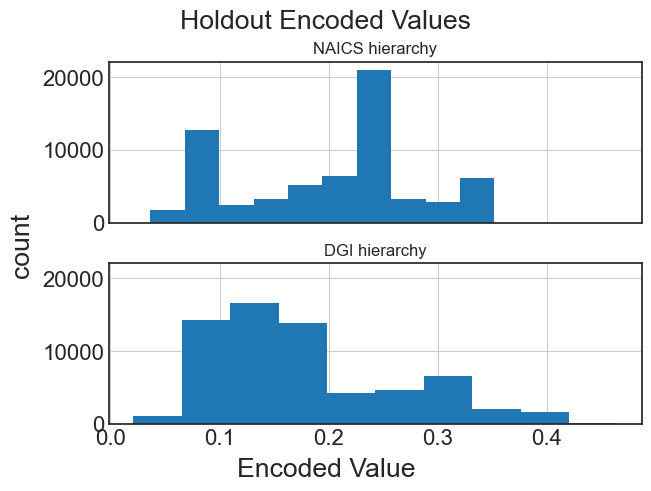

In [28]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True,
                       layout='constrained')
pred_naics_ho['mhier_NAICS'].hist(ax=ax[0])
ax[0].set_title('NAICS hierarchy', size=12)
pred_dgi_ho['menc_dgi'].hist(ax=ax[1])
ax[1].set_title('DGI hierarchy', size=12)
#ax[1].set_xlim([0,0.5])
fig.supylabel('count')
fig.supxlabel('Encoded Value')
fig.suptitle('Holdout Encoded Values')

Text(0.5, 0.98, 'All Encoded Values')

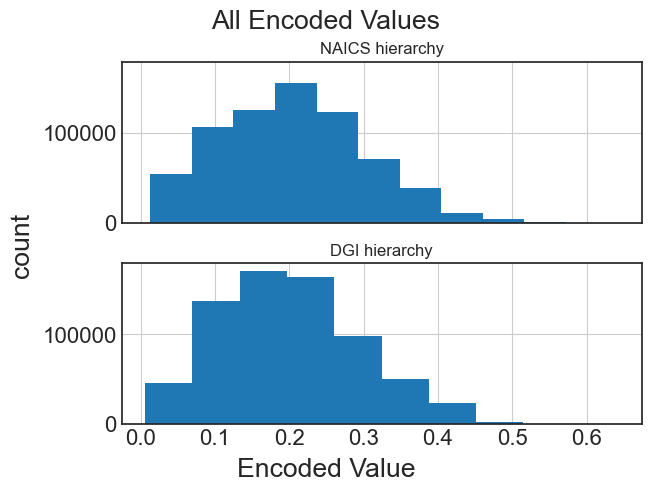

In [29]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True,
                       layout='constrained')
pred_naics['mhier_NAICS'].hist(ax=ax[0])
ax[0].set_title('NAICS hierarchy', size=12)
pred_dgi['menc_dgi'].hist(ax=ax[1])
ax[1].set_title('DGI hierarchy', size=12)
#ax[1].set_xlim([0,0.5])
fig.supylabel('count')
fig.supxlabel('Encoded Value')
fig.suptitle('All Encoded Values')

## Histograms - By NAICS

In [30]:
# Function to get error, other information by NAICS
def get_err_by_naics(pred_df, hier_feat = 'menc_dgi'):
    ho_sum = pred_df \
        .groupby(['NAICS', hier_feat]) \
        .agg({'LoanNr_ChkDgt':'count', 'target':['sum', 'mean'], 'predict_prob':'mean',
              'predict_bin':'sum'}) \
    .reset_index()  
    ho_sum.columns = [re.sub('_$', '', '_'.join(c)) for c in ho_sum.columns]
    ho_sum.rename(columns={'LoanNr_ChkDgt_count':'count'}, inplace=True)
    ho_sum['prob_err'] = ho_sum['predict_prob_mean'] - ho_sum['target_mean']
    return ho_sum

In [31]:
pred_dgi_grp = get_err_by_naics(pred_dgi)
pred_naics_grp = get_err_by_naics(pred_naics, 'mhier_NAICS')

In [32]:
pred_dgi_grp_ho = get_err_by_naics(pred_dgi_ho)
pred_naics_grp_ho = get_err_by_naics(pred_naics_ho, 'mhier_NAICS')

Text(0.5, 0.98, 'Holdout Encoded Values (NAICS level)')

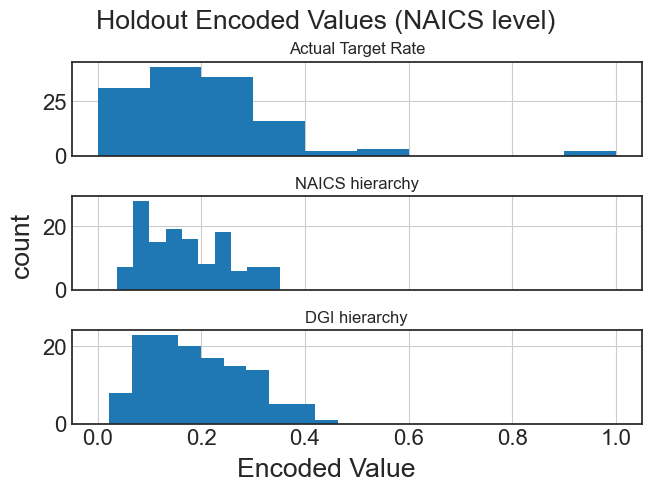

In [33]:
# Histogram- holdout by NAICS
fig, ax = plt.subplots(3,1, sharex=True, sharey=False,
                       layout='constrained')
pred_naics_grp_ho['target_mean'].hist(ax=ax[0])
ax[0].set_title('Actual Target Rate', size=12)
pred_naics_grp_ho['mhier_NAICS'].hist(ax=ax[1])
ax[1].set_title('NAICS hierarchy', size=12)
pred_dgi_grp_ho['menc_dgi'].hist(ax=ax[2])
ax[2].set_title('DGI hierarchy', size=12)
#ax[2].set_xlim([0,0.5])
fig.supylabel('count')
fig.supxlabel('Encoded Value')
fig.suptitle('Holdout Encoded Values (NAICS level)')

Text(0.5, 0.98, 'All Encoded Values')

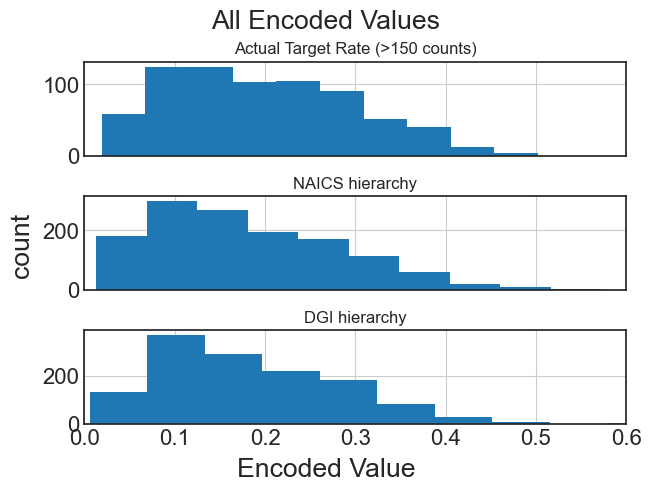

In [34]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False,
                       layout='constrained')
pred_naics_grp[pred_naics_grp['count'] >= 100]['target_mean'].hist(ax=ax[0])
ax[0].set_title('Actual Target Rate (>150 counts)', size=12)
pred_naics_grp['mhier_NAICS'].hist(ax=ax[1])
ax[1].set_title('NAICS hierarchy', size=12)
pred_dgi_grp['menc_dgi'].hist(ax=ax[2])
ax[2].set_title('DGI hierarchy', size=12)
ax[2].set_xlim([0,0.6])
fig.supylabel('count')
fig.supxlabel('Encoded Value')
fig.suptitle('All Encoded Values')

## Holdout - error analysis by NAICS

<Axes: xlabel='menc_dgi', ylabel='prob_err'>

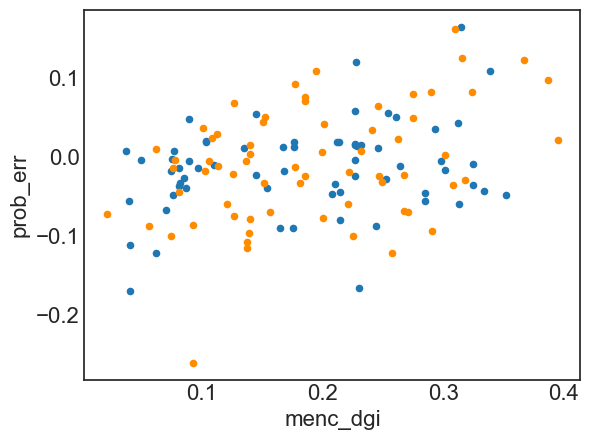

In [35]:
fig, ax = plt.subplots()
pred_naics_grp_ho[pred_naics_grp_ho['count'] >= 100].plot(x='mhier_NAICS', y='prob_err', kind='scatter', ax=ax)
pred_dgi_grp_ho[pred_dgi_grp_ho['count'] >= 100] \
    .plot(x='menc_dgi', y='prob_err', kind='scatter', ax = ax, color='darkorange')

## Sub-metrics

In [36]:
bins = [-np.Inf, 0.2, np.Inf]
pred_dgi_ho['pred_cut'] = pd.cut(pred_dgi_ho['menc_dgi'], bins=bins)

In [37]:
metrics_dgi_sub = pred_dgi_ho.groupby('pred_cut') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_dgi_sub

,pred_cut,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
0,"(-inf, 0.2]",0.800967,0.280176,0.301868,0.261394,0.285785,0.715709
1,"(0.2, inf]",0.487676,0.468094,0.321540,0.860132,0.374741,0.655205


In [38]:
pred_naics_ho['pred_cut'] = pd.cut(pred_naics_ho['mhier_NAICS'],  bins=bins)

In [39]:
metrics_naics_sub = pred_naics_ho.groupby('pred_cut') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_naics_sub

,pred_cut,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
0,"(-inf, 0.2]",0.831629,0.256321,0.297090,0.225391,0.247685,0.693689
1,"(0.2, inf]",0.606782,0.462433,0.327787,0.784813,0.402475,0.733532


##### Overall test data perf
Random selection

In [40]:
pred_naics_test = pred_naics[pred_naics['dset_naics_holdout'] ==  0].copy()
pred_dgi_test = pred_dgi[pred_dgi['dset_naics_holdout'] ==  0].copy()
pred_dgi_test['pred_cut'] = pd.cut(pred_dgi_test['menc_dgi'], bins=bins)
pred_naics_test['pred_cut'] = pd.cut(pred_naics_test['mhier_NAICS'],  bins=bins)

In [41]:
pred_naics_test.groupby('pred_cut') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()

,pred_cut,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
0,"(-inf, 0.2]",0.819585,0.313959,0.298265,0.331396,0.272064,0.736541
1,"(0.2, inf]",0.513683,0.490681,0.348543,0.828584,0.424507,0.668589


In [42]:
pred_dgi_test.groupby('pred_cut') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()

,pred_cut,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
0,"(-inf, 0.2]",0.813214,0.317851,0.296513,0.342498,0.273817,0.735094
1,"(0.2, inf]",0.509217,0.488133,0.345525,0.831185,0.419338,0.666791


##### Training performance

In [43]:
pred_naics_train = pred_naics[pred_naics['dset'] ==  'train'].copy()
pred_dgi_train = pred_dgi[pred_dgi['dset'] ==  'train'].copy()
pred_dgi_train['pred_cut'] = pd.cut(pred_dgi_train['menc_dgi'], bins=bins)
pred_naics_train['pred_cut'] = pd.cut(pred_naics_train['mhier_NAICS'],  bins=bins)

In [44]:
pred_naics_train.groupby('pred_cut') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()

,pred_cut,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
0,"(-inf, 0.2]",0.820685,0.313185,0.295814,0.332724,0.271698,0.738521
1,"(0.2, inf]",0.514646,0.492109,0.349736,0.829986,0.427499,0.670211


In [45]:
pred_dgi_train.groupby('pred_cut') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()

,pred_cut,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
0,"(-inf, 0.2]",0.814443,0.317268,0.294545,0.343792,0.273254,0.736698
1,"(0.2, inf]",0.510193,0.489541,0.346685,0.832642,0.422421,0.668602


## Precision-Recall Curves

In [46]:
def get_pr_curve(pred_df):
    cd = sk.metrics.precision_recall_curve(pred_df['target'], pred_df['predict_prob'])
    return pd.DataFrame({'precision':cd[0],
                         'recall': cd[1]})

##### Compare overalls, holdouts

In [47]:
pr_curve_dgi = get_pr_curve(pred_dgi[pred_dgi['dset'] == 'test'])
pr_curve_dgi_ho = get_pr_curve(pred_dgi_ho)

In [48]:
pr_curve_naics = get_pr_curve(pred_naics[pred_naics['dset'] == 'test'])
pr_curve_naics_ho = get_pr_curve(pred_naics_ho)

Text(0.5, 1.0, 'Holdout NAICS')

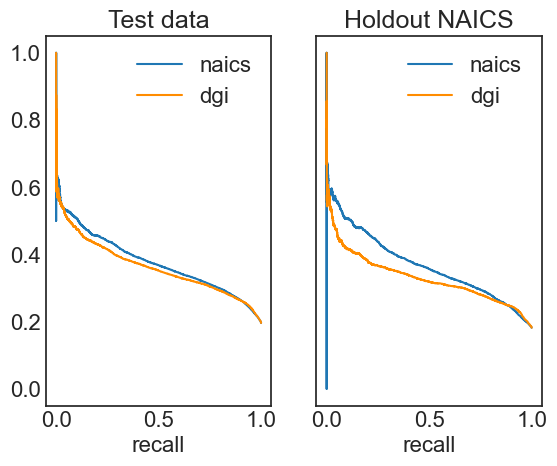

In [49]:
fig, ax = plt.subplots(1, 2, sharey=True)
pr_curve_naics.plot(x='recall', y='precision', ax=ax[0], label='naics')
pr_curve_dgi.plot(x='recall', y='precision', ax=ax[0],color='darkorange', label='dgi')
ax[0].set_title('Test data')
pr_curve_naics_ho.plot(x='recall', y='precision', ax=ax[1], label='naics')
pr_curve_dgi_ho.plot(x='recall', y='precision', ax=ax[1], color='darkorange', label='dgi')
ax[1].set_title('Holdout NAICS')

##### Break Down Values

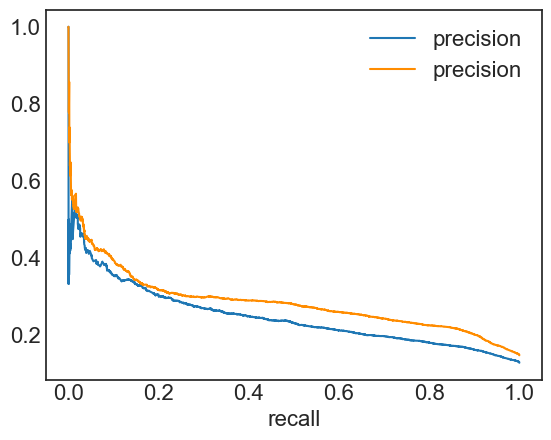

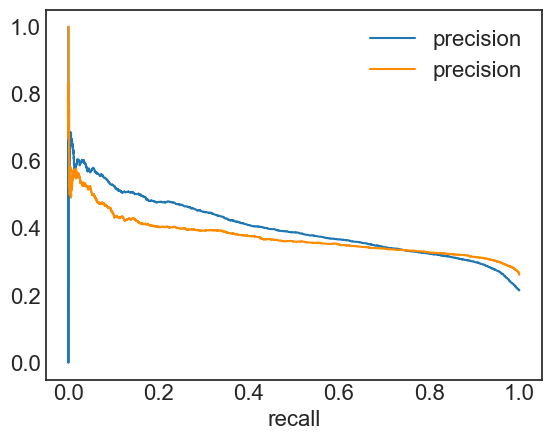

In [50]:
#ig, ax = plt.subplots()
b = [0, 0.2, np.Inf]
for i in range(len(b)-1):
    this_curve_naics = get_pr_curve(pred_naics_ho[(pred_naics_ho['mhier_NAICS'] >=b[i]) & \
                                   (pred_naics_ho['mhier_NAICS'] <=b[i+1])])
    this_curve_dgi = get_pr_curve(pred_dgi_ho[(pred_dgi_ho['menc_dgi'] >=b[i]) & \
                                   (pred_dgi_ho['menc_dgi'] <=b[i+1])])
    fig, ax = plt.subplots()
    this_curve_naics.plot(x='recall', y='precision', ax=ax)
    this_curve_dgi.plot(x='recall', y='precision', ax=ax,color='darkorange')
    plt.show()